# Project Image recognition (with ResNets)

The goal is to train a neural network for visual recognition (i.e., given an image, predict its class label). Below is the original article explaining the details so called residual networks (ResNets), i.e., current state-of-the-art architecture for this type of problem. The task is to implement a ResNet and feel free to adjust things where you see fit. *Do not just copy the PyTorch example. Try to assess which parts of the architecture are more relevant than others recognition performance.

Resources: MNIST and CIFAR-10/100 data available via PyTorch

In [7]:
import torch
import torchvision
import torchvision.transforms as transforms

We download our data set the MNIST:

In [8]:
trainSet = torchvision.datasets.MNIST(
    root='./data/MNIST', 
    train=True, 
    download=True,
    transform=transforms.Compose([
        transforms.ToTensor()
    ]), 

)
trainLoader = torch.utils.data.DataLoader(
    trainSet, batch_size = 10
)


Lets have a look at our data:

In [9]:
import numpy as np
import matplotlib.pyplot as plt

torch.set_printoptions(linewidth=120)

In [10]:
len(trainSet)

60000

In [11]:
trainSet.train_labels

tensor([5, 0, 4,  ..., 5, 6, 8])

In [12]:
trainSet.train_labels.bincount()

tensor([5923, 6742, 5958, 6131, 5842, 5421, 5918, 6265, 5851, 5949])

In [13]:
sample = next(iter(trainSet))
len(sample)


2

In [14]:
type(sample)

tuple

In [15]:
image, label = sample

In [16]:
image.shape

torch.Size([1, 28, 28])

In [17]:
label.shape

torch.Size([])

label: tensor(5)


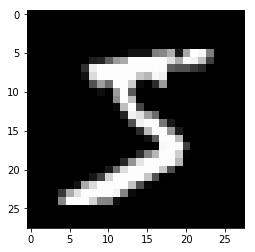

In [18]:
plt.imshow(image.squeeze(), cmap='gray')
print('label:', label)

In [19]:
batch = next(iter(trainLoader))
len(batch)

2

In [20]:
type(batch)

list

In [21]:
images, labels = batch
images.shape

torch.Size([10, 1, 28, 28])

labels: tensor([5, 0, 4, 1, 9, 2, 1, 3, 1, 4])


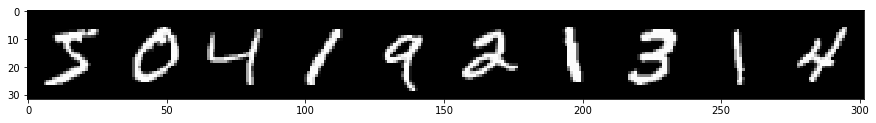

In [22]:
grid = torchvision.utils.make_grid(images, nrow = 10)

plt.figure(figsize=(15, 15))
plt.imshow(np.transpose(grid, (1,2,0)))

print('labels:', labels)

# ResNet implemenation

In [23]:
from torch import nn

In [26]:
def conv3x3(in_planes, out_planes, stride=1):
    """3x3 convolution with padding"""
    return nn.Conv2d(in_planes,
                     out_planes,
                     kernel_size=3,
                     stride=stride,
                     padding=1,
                     bias=False)

def conv1x1(in_planes, out_planes, stride=1):
    """1x1 convolution"""
    return nn.Conv2d(
        in_planes,
        out_planes,
        kernel_size = 1,
        stride = stride,
        bias=False)

In [27]:
# First test:
l = conv3x3(10,20,stride=1)
print(l(torch.randn(4,10,32,32)).size())

torch.Size([4, 20, 32, 32])


We create a class that implements the residual block:

In [37]:
class BasicBlock_v1(nn.Module):
    expansion = 1
    
    def __init__(self, inplanes, planes, stride=1):
        super(BasicBlock_v1, self).__init__()
        
        """
        3x3 convolution inplanes -> outplanes 
        (spatial size maintianed), BN + ReLU
        """
        self.conv1 = conv3x3(inplanes, planes, stride)
        self.bn1 = nn.BatchNorm2d(planes)
        self.relu = nn.ReLU(inplace=True)
        self.conv2 = conv3x3(planes, planes)
        self.bn2 = nn.BatchNorm2d(planes)
        self.stride = stride
        self.downsample = downsample
        
        """
        3x3 convolution inplanes -> outplanes
        (spatial size maintained) + BN
        """
        self.conv2 = conv3x3(planes, planes)
        self.bn2 = nn.BatchNorm2d(planes)
        
    def forward(self, x):
        residual = x # save x
        
        # conv -> bn -> relu
        out = self.conv1(x)
        out = self.bn1(out)
        out = self.relu(out)
        
        # conv -> bn
        out = self.conv2(out)
        out = self.bn2(out)
        
        # x + F(x) - this realizes the shortcut conn.
        out += residual
        out = self.relu(out) # final relu
        
        return out

In [38]:
# test input data, batch size 4, 32 channels, spatial dim 12x12.
x = torch.randn(4, 64, 12, 12)

# Push this data through basic block
bb = BasicBlock_v1(64,64)
print(bb(x).size())

torch.Size([4, 64, 12, 12])


In [33]:
class BasicBlock_v2(nn.Module):
    expansion = 1
    
    def __init__(self, inplanes, planes, stride=1, downsample=None):
        super(BasicBlock_v2, self).__init__()
        
        self.conv1 = conv3x3(inplanes, planes, stride)
        self.bn1 = nn.BatchNorm2d(planes)
        self.relu = nn.ReLU(inplace=True)
        self.conv2 = conv3x3(planes, planes)
        self.bn2 = nn.BatchNorm2d(planes)
        self.stride = stride
        self.downsample = downsample
        
    def forward(self, x):
        residual = x # save x
        
        # conv -> bn -> relu
        out = self.conv1(x)
        out = self.bn1(out)
        out = self.relu(out)
        out = self.conv2(out)
        out = self.bn2(out)
        
        if self.downsample is not None:
            residual = self.downsample(x)
        
        # x + F(x) - this realizes the shortcut conn.
        out += residual
        out = self.relu(out) # final relu
        
        return out

down_fn = conv1x1(64,64,stride=2)

x = torch.randn(4, 64, 12,12)

bb = BasicBlock_v2(64,64,stride=2, downsample=down_fn)

print(bb(x).size())

# Bottleneck block

In [36]:
class Bottleneck(nn.Module):
    """
    The expansion factor controls the number of output
    channels of the last 1x1 convolution layer.
    """
    expansion = 4
    
    def __init__(self, inplanes, planes, stride = 1, downsample=None):
        super(Bottleneck, self).__init__()
        
        self.conv1 = conv1x1(inplanes, planes)
        self.bn1 = nn.BatchNorm2d(planes)
        self.conv2 = conv3x3(planes, planes, stride)
        self.bn2 = nn.BatchNorm2d(planes)
        self.conv3 = conv1x1(planes, planes * self.expansion)
        self.bn3 = nn.BatchNorm2d(planes*self.expansion)
        self.relu = nn.ReLU(inplace=True)
        self.downsample = downsample
        self.stride = stride
        
    def forward(self, x):
        residual = x
    
        out = self.conv1(x)
        out = self.bn1(out)
        out = self.relu(out)
        
        out = self.conv2(out)
        out = self.bn2(out)
        out = self.relu(out)
        
        out = self.conv3(out)
        out = self.bn3(out)
        
        if self.downsample is not None:
            residual = self.downsample(x)
            
        out += residual
        out = self.relu(out)
        
        return out
        

In [39]:
down_fn = conv1x1(256,256,stride=2)
x = torch.randn(4,256,12,12)
bb = Bottleneck(256,64,stride=2, downsample=down_fn)
print(bb(x).size())

torch.Size([4, 256, 6, 6])


# Actual ResNet implementation:

In [41]:
from torchvision.models import resnet18